Unwanted stuff needed to run cv2 in python3

In [1]:
import sys
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
# sys.path.remove('/home/kramer/Documents/ROS/catkin_ws/devel/lib/python2.7/dist-packages')

### Background substraction

In [2]:
from imageio import imread, imwrite
import numpy as np
import matplotlib.pyplot as plt

threshold = 45

img = np.array(imread("test/test_4.jpg"), dtype=int)
background = np.array(imread("background.jpg"), dtype=int)
img_diff = np.clip(np.abs(img - background), 0, 255)
img_diff = np.array(img_diff, dtype=np.uint8)

small_brightness_pixels = np.where(img_diff < threshold)
img_diff[small_brightness_pixels] = 0

# high_brightness_pixels = np.where(img_diff > threshold)
# img_diff[high_brightness_pixels] = 255


fig = plt.figure(1, (20,8))
fig.add_subplot(1, 3, 1)
plt.imshow(background)
fig.add_subplot(1, 3, 2)
plt.imshow(img)
fig.add_subplot(1, 3, 3)
plt.imshow(img_diff)

plt.show()

<Figure size 2000x800 with 3 Axes>

### Convert mask to grayscale

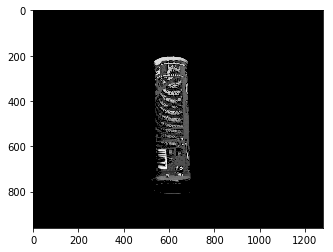

In [3]:
import cv2
im2 = cv2.cvtColor(img_diff,cv2.COLOR_BGR2GRAY)
plt.imshow(im2, cmap='gray')
plt.show()

### Generate bounding box using mask

In [4]:
nonzero_rows, nonzero_cols = np.where(im2)
min_i, max_i = (np.min(nonzero_rows), np.max(nonzero_rows))
min_j, max_j = (np.min(nonzero_cols), np.max(nonzero_cols))
# indices = np.meshgrid(np.arange(np.min(i), np.max(i) + 1),
#                       np.arange(np.min(j), np.max(j) + 1),
#                       indexing='ij')
# plt.imshow(im2[min_i:max_i, min_j:max_j], cmap='gray')
# plt.show()

# cv2.rectangle(im2,(min_j,min_i),(max_j,max_i),(255,255,255),2)
# cv2.imshow('Features', im2)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

### Locate mask with bounding in artificial image

In [58]:
nonzero_rows, nonzero_cols = np.where(im2)
min_i, max_i = (np.min(nonzero_rows), np.max(nonzero_rows))
min_j, max_j = (np.min(nonzero_cols), np.max(nonzero_cols))

back_image = imread('apartment.jpg')
# obj_rectangle = np.where(im2[min_i:max_i, min_j:max_j] > 0)

# back_image[i, j] = img[i, j]
# plt.figure(figsize=(20,10))
# plt.imshow(back_image)
# plt.show()
# cv2.rectangle(back_image,(min_j,min_i),(max_j,max_i),(255,255,255),2)
# cv2.imshow('Features', back_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

### Generating artificial images:
* Translation
* Rotation
* Scaling?

In [ ]:
print(np.array([min_i, max_i]))
print(np.array([min_j, max_j]))
print(bb)

In [59]:
def generate_transformation(back_image, min_max_i, min_max_j):
    min_i, max_i = min_max_i
    min_j, max_j = min_max_j
    rectangle_points = np.array([[min_i, min_i, max_i, max_i],
                                 [min_j, max_j, min_j, max_j]])
    rectangle_points = np.vstack((rectangle_points, [1., 1., 1., 1.]))

    random_rot_angle = np.random.uniform(0, 2*np.pi)
    random_rot_matrix = np.array([[np.cos(random_rot_angle), -np.sin(random_rot_angle)],
                                  [np.sin(random_rot_angle), np.cos(random_rot_angle)]])
    random_translation_x = np.random.uniform(-min_i, back_image.shape[1]-max_i)
    random_translation_y = np.random.uniform(-min_j, back_image.shape[0]-max_j)
    translation_vector = np.array([[random_translation_x], [random_translation_y]])

    t = np.hstack((random_rot_matrix, translation_vector))
    t = np.vstack((t, np.array([0., 0., 1.])))

    transformed_bb = t.dot(rectangle_points)
    transformed_bb = np.array(transformed_bb, dtype=int)

    use_transformation = True
    for point in transformed_bb.T:
        if point[0] < 0 or point[0] > back_image.shape[0] or \
           point[1] < 0 or point[1] > back_image.shape[1]:
            use_transformation = False
            break
    return t, use_transformation

In [64]:
use_transformation = False
t = None
while not use_transformation:
    t, use_transformation = generate_transformation(back_image,
                                                    (min_i, max_i),
                                                    (min_j, max_j))

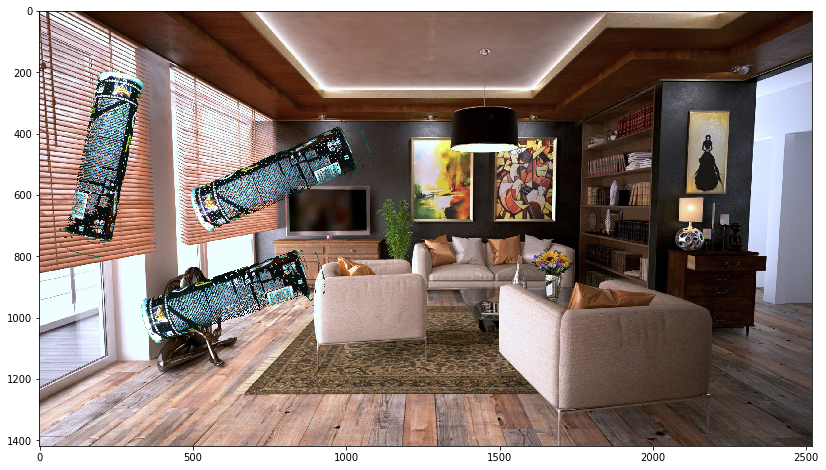

In [65]:
obj_coords = np.vstack((nonzero_rows[np.newaxis],
                        nonzero_cols[np.newaxis],
                        np.ones(len(nonzero_rows), dtype=int)))

# t = np.array([[np.cos(np.pi/4.), -np.sin(np.pi/4.), 200.], [np.sin(np.pi/4.), np.cos(np.pi/4.), 500.], [0., 0., 1.]])
transformed_obj_coords = t.dot(obj_coords)
transformed_obj_coords = np.array(transformed_obj_coords, dtype=int)

for i, point in enumerate(transformed_obj_coords.T):
    x = point[0]
    y = point[1]

    back_image[x, y] = img[obj_coords[0, i], obj_coords[1, i]]

fig = plt.figure(figsize=(20,8))
plt.imshow(back_image)
plt.show()